In [ ]:
import numpy as np
import pandas as pd
import os
from librosa import feature
import librosa 
import matplotlib.pyplot as plt
import IPython.display as ipd  # To play sound in the notebook
import librosa.display
import json
from matplotlib.pyplot import specgram
import seaborn as sns
import glob 
from tqdm import tqdm
import pickle
from PIL import Image
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
from torch.autograd import Variable
from torchvision import models

In [ ]:
sec30_data = pd.read_csv('features_30_sec.csv')

In [ ]:
sec30_data.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [ ]:
sec3_data = pd.read_csv('features_3_sec.csv')

In [ ]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [ ]:
genre_dict = {
    'blues': 0,
    'classical': 1,
    'country': 2,
    'disco': 3,
    'hiphop': 4,
    'jazz': 5,
    'metal': 6,
    'pop': 7,
    'reggae': 8,
    'rock': 9,
    }

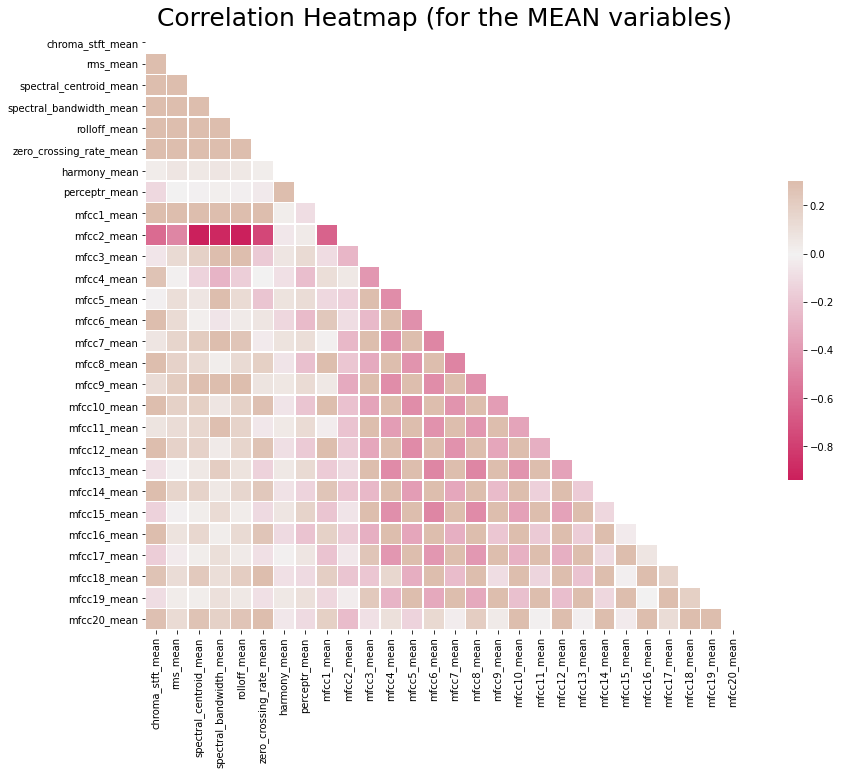

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in sec30_data.columns if 'mean' in col]
corr = sec30_data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

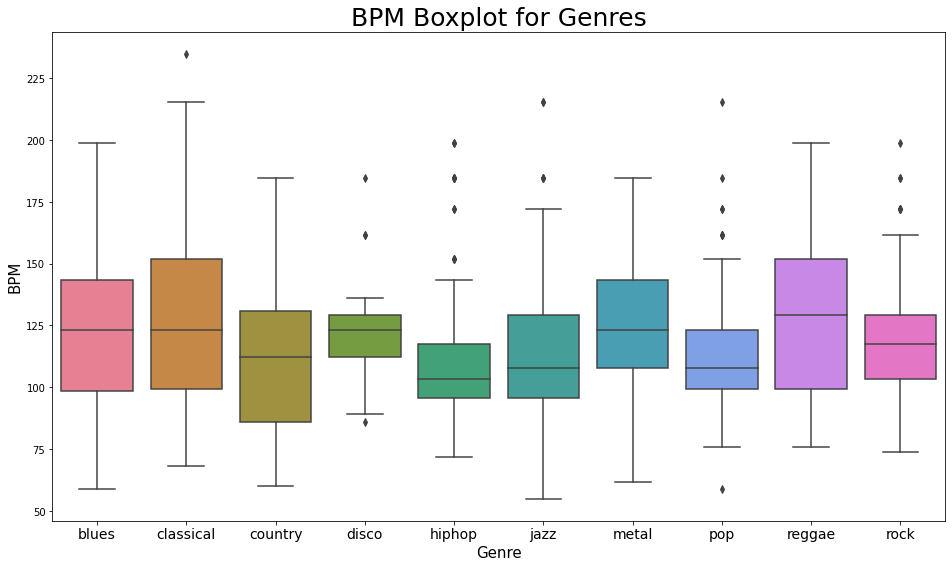

In [ ]:
x = sec30_data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

Text(0, 0.5, 'mfcc1_mean')

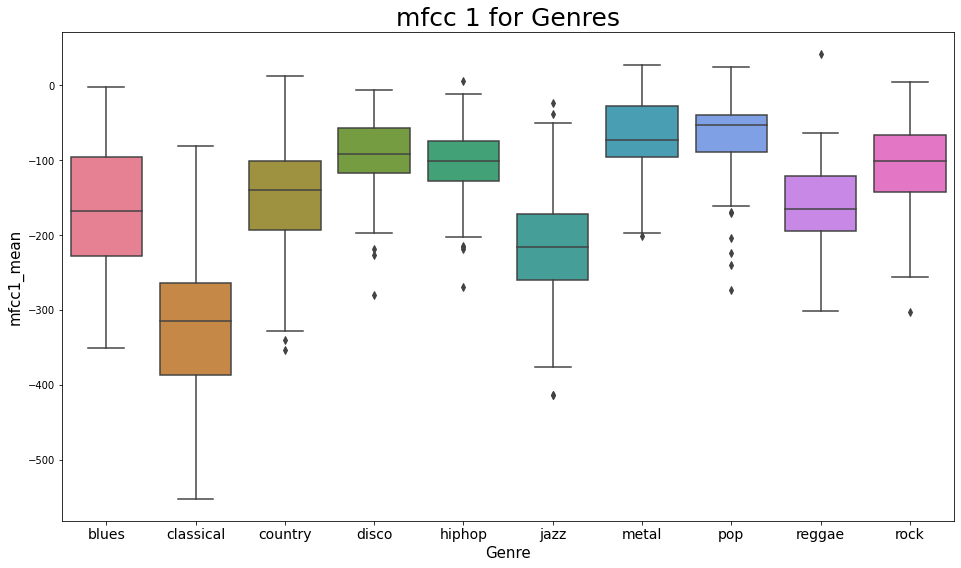

In [ ]:
x = sec30_data[["label", "mfcc1_mean"]]
f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "mfcc1_mean", data = x, palette = 'husl');

plt.title('mfcc 1 for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("mfcc1_mean", fontsize = 15)

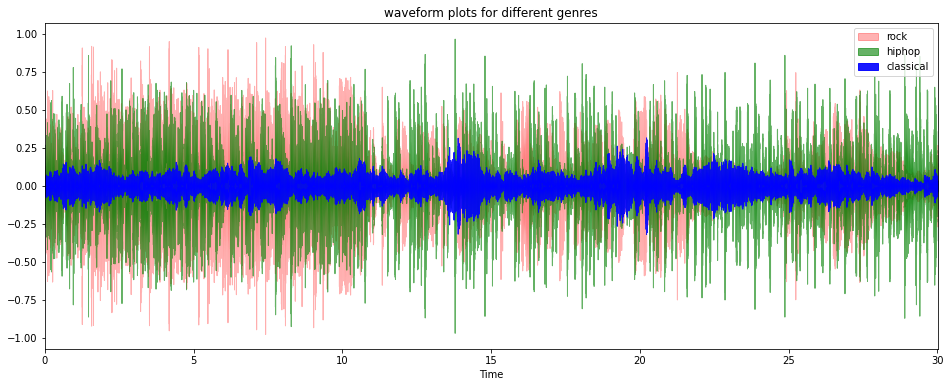

In [ ]:
rock, sr = librosa.load(f'/content/rock.00000.wav')
hiphop, sr = librosa.load(f'/content/hiphop.00000.wav')
classical, sr = librosa.load(f'/content/classical.00000.wav')

plt.figure(figsize = (16, 6))
librosa.display.waveplot(y = rock, sr = sr, alpha = 0.3, color = 'r', label = 'rock')
librosa.display.waveplot(y = hiphop, sr = sr, alpha = 0.6, color = 'g', label = 'hiphop')
librosa.display.waveplot(y = classical, sr = sr, alpha = 0.9, color = 'b', label = 'classical')
plt.title('waveform plots for different genres')
plt.legend()


In [ ]:
from sklearn import preprocessing
features = ['chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var']

X = sec30_data.loc[:,features]
y =  pd.factorize(sec30_data['label'])[0]

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns = cols)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle = True)

In [ ]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [ ]:
BATCH_SIZE = 16

torch_X_train = torch.cuda.FloatTensor(X_train)
torch_y_train = torch.cuda.LongTensor(y_train)

torch_X_test = torch.cuda.FloatTensor(X_test)
torch_y_test = torch.cuda.LongTensor(y_test)

# Pytorch train and test data sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle = False)

In [ ]:
class MusicCNN(nn.Module):
    def __init__(self):
        super(MusicCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=57, out_channels=64, kernel_size=1, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.AvgPool1d(kernel_size=2)

        self.conv2 =nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.AvgPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=1, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.AvgPool1d(kernel_size=2)

        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=1, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.AvgPool1d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=512, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)
        #x = F.dropout(F.relu(self.fc1(x)), 0.5)
        #x = F.dropout(F.relu(self.fc2(x)))
        #x = F.dropout(F.relu(self.fc3(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        #x = x.view(x.size(0), -1)
        return x

    def _init_weights(self, layer) -> None:
        if isinstance(layer, nn.Conv1d):
            nn.init.kaiming_uniform_(layer.weight)
        elif isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)

In [ ]:
model = MusicCNN()
model.cuda()
error = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
loss_list = []
acc_list = []
EPOCHS = 200
model.train()
for epoch in range(EPOCHS):
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        output = model(var_X_batch)
        loss = error(output, var_y_batch)
        loss.backward()
        optimizer.step()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1] 
        correct += (predicted == var_y_batch).sum()
        # print(correct)
    loss_list.append(loss.data)
    acc_list.append(float(correct) / float(BATCH_SIZE*(batch_idx+1)))
    print('Epoch : {} \tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(epoch, loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 0 	Loss: 2.301710	 Accuracy:13.690%
Epoch : 1 	Loss: 2.300882	 Accuracy:16.815%
Epoch : 2 	Loss: 2.296405	 Accuracy:18.750%
Epoch : 3 	Loss: 2.301786	 Accuracy:20.982%
Epoch : 4 	Loss: 2.298487	 Accuracy:21.429%
Epoch : 5 	Loss: 2.301835	 Accuracy:22.470%
Epoch : 6 	Loss: 2.300585	 Accuracy:23.363%
Epoch : 7 	Loss: 2.299767	 Accuracy:23.214%
Epoch : 8 	Loss: 2.301659	 Accuracy:23.958%
Epoch : 9 	Loss: 2.297940	 Accuracy:25.149%
Epoch : 10 	Loss: 2.299397	 Accuracy:22.321%
Epoch : 11 	Loss: 2.281586	 Accuracy:24.256%
Epoch : 12 	Loss: 2.301361	 Accuracy:22.619%
Epoch : 13 	Loss: 2.270793	 Accuracy:21.429%
Epoch : 14 	Loss: 2.305100	 Accuracy:19.494%
Epoch : 15 	Loss: 2.287158	 Accuracy:16.071%
Epoch : 16 	Loss: 2.310370	 Accuracy:13.244%
Epoch : 17 	Loss: 2.223815	 Accuracy:12.649%
Epoch : 18 	Loss: 2.312632	 Accuracy:11.607%
Epoch : 19 	Loss: 2.264104	 Accuracy:14.732%
Epoch : 20 	Loss: 2.321415	 Accuracy:18.601%
Epoch : 21 	Loss: 2.249611	 Accuracy:22.173%
Epoch : 22 	Loss: 2.

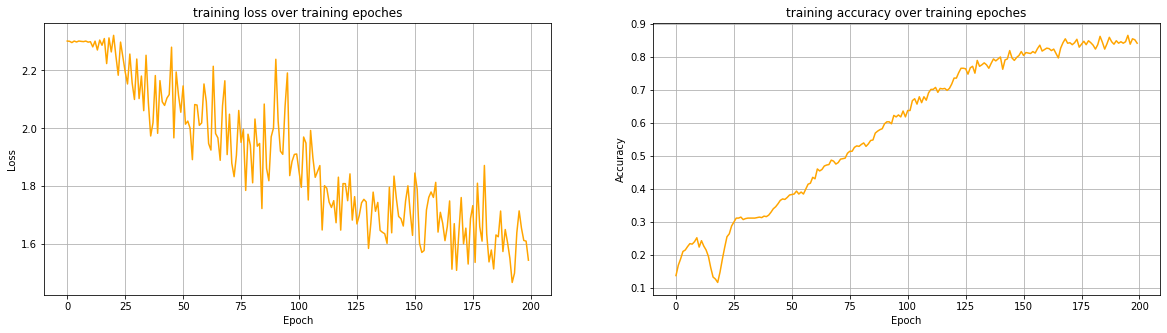

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].grid()
axs[0].plot(np.arange(EPOCHS), loss_list, color = 'orange')
axs[0].set(xlabel='Epoch', ylabel='Loss')
axs[0].title.set_text('training loss over training epoches')

axs[1].grid()
axs[1].plot(np.arange(EPOCHS), acc_list, color = 'orange')
axs[1].set(xlabel='Epoch', ylabel='Accuracy')
axs[1].title.set_text('training accuracy over training epoches') 

In [ ]:
def test_acc(model, test_set):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            outputs = model(images)
            predicted = torch.max(outputs.data, 1)[1] 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test features: %d %%' % (100 * correct / total))

test_acc(model, test_loader)

Accuracy of the network on the test features: 78 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
